## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras

Using TensorFlow backend.


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = [1e-1, 1e-2, 1e-3]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for lr in LEARNING_RATE:
    #有 nesterov
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f with nesterov" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, momentum=MOMENTUM, nesterov=True)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s-nesterov" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
    #沒有 nesterov
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f without nesterov" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, momentum=MOMENTUM, nesterov=False)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s-no_nesterov" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    


Experiment with LR = 0.100000 with nesterov
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/500

50000/50000 [==============================] - 2s 39us/step - loss: 2.3045 - accuracy: 0.0987 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.3041 - accuracy: 0.1017 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.3043 - accuracy: 0.0992 - val_loss: 2.3051 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.3044 - accuracy: 0.1018 - val_loss: 2.3032 - val_accuracy: 0.1000
Experiment with LR = 0.100000 without nesterov
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
__________________________

Epoch 45/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.3041 - accuracy: 0.1005 - val_loss: 2.3063 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 2s 38us/step - loss: 2.3042 - accuracy: 0.0987 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.3046 - accuracy: 0.0978 - val_loss: 2.3043 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.3042 - accuracy: 0.1008 - val_loss: 2.3049 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.3042 - accuracy: 0.1005 - val_loss: 2.3041 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.3043 - accuracy: 0.0997 - val_loss: 2.3035 - val_accuracy: 0.1000
Experiment with LR = 0.010000 with nesterov
Model: "model_1"
___________________________________________________

Epoch 43/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.4737 - accuracy: 0.8292 - val_loss: 2.0066 - val_accuracy: 0.5277
Epoch 44/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.4563 - accuracy: 0.8359 - val_loss: 2.0393 - val_accuracy: 0.5242
Epoch 45/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.4476 - accuracy: 0.8382 - val_loss: 2.0792 - val_accuracy: 0.5237
Epoch 46/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.4163 - accuracy: 0.8501 - val_loss: 2.1237 - val_accuracy: 0.5288
Epoch 47/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.4051 - accuracy: 0.8532 - val_loss: 2.2933 - val_accuracy: 0.5066
Epoch 48/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.3927 - accuracy: 0.8586 - val_loss: 2.1891 - val_accuracy: 0.5217
Epoch 49/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.3824 - accuracy: 0.8632 - val_

Epoch 41/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.7425 - accuracy: 0.7323 - val_loss: 1.5505 - val_accuracy: 0.5285
Epoch 42/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.7403 - accuracy: 0.7336 - val_loss: 1.5619 - val_accuracy: 0.5349
Epoch 43/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.7138 - accuracy: 0.7440 - val_loss: 1.5694 - val_accuracy: 0.5315
Epoch 44/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.6957 - accuracy: 0.7490 - val_loss: 1.6019 - val_accuracy: 0.5327
Epoch 45/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.6867 - accuracy: 0.7519 - val_loss: 1.6719 - val_accuracy: 0.5269
Epoch 46/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.6824 - accuracy: 0.7530 - val_loss: 1.6026 - val_accuracy: 0.5290
Epoch 47/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.6615 - accuracy: 0.7613 - val_

Epoch 39/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.0149 - accuracy: 0.6438 - val_loss: 1.4064 - val_accuracy: 0.5163
Epoch 40/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.0008 - accuracy: 0.6493 - val_loss: 1.4779 - val_accuracy: 0.4991
Epoch 41/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9853 - accuracy: 0.6547 - val_loss: 1.3683 - val_accuracy: 0.5221
Epoch 42/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.9727 - accuracy: 0.6584 - val_loss: 1.3929 - val_accuracy: 0.5244
Epoch 43/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.9633 - accuracy: 0.6613 - val_loss: 1.4387 - val_accuracy: 0.5157
Epoch 44/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.9501 - accuracy: 0.6672 - val_loss: 1.3514 - val_accuracy: 0.5341
Epoch 45/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.9385 - accuracy: 0.6708 - val_

Epoch 37/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.0970 - accuracy: 0.6134 - val_loss: 1.3540 - val_accuracy: 0.5241
Epoch 38/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.0883 - accuracy: 0.6167 - val_loss: 1.3543 - val_accuracy: 0.5282
Epoch 39/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.0744 - accuracy: 0.6220 - val_loss: 1.3064 - val_accuracy: 0.5383
Epoch 40/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.0683 - accuracy: 0.6234 - val_loss: 1.3370 - val_accuracy: 0.5278
Epoch 41/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.0620 - accuracy: 0.6253 - val_loss: 1.3251 - val_accuracy: 0.5312
Epoch 42/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.0429 - accuracy: 0.6333 - val_loss: 1.3834 - val_accuracy: 0.5161
Epoch 43/50
50000/50000 [==============================] - 2s 37us/step - loss: 1.0301 - accuracy: 0.6379 - val_

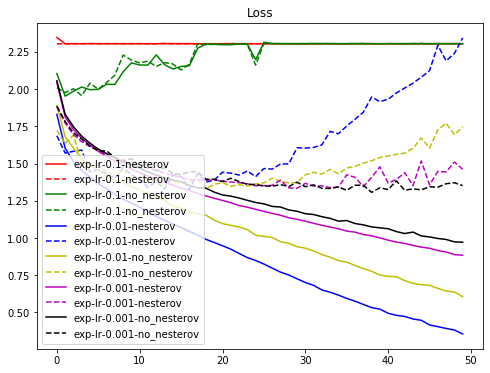

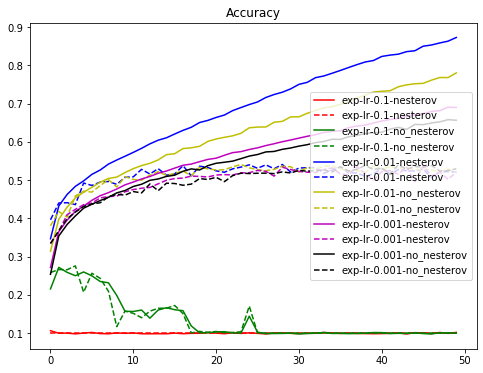

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()